# Support Vector Machines (SVMs)

Tingting Yang

INDE 577 - Data Science and Machine Learning

# Introduction

[Support Vector Machine (SVM)](https://en.wikipedia.org/wiki/Support-vector_machine) algorithm is a powerful supervised machine learning algorithm, which can be used in both regression and classification problems. 

There are two types of SVM, linear SVM (simple SVM) and non-linear SVM (kernel SVM). Linear SVM is used for linearly separable data, while the non-linear SVM is used for non-linearly separated data.

The goal of the SVM algorithm is to create the best decision boundary to separate the classes. To achieve the goal, it finds the maximum distance from the nearest points of two classes, and this optimal decision boundary is called support vectors. The region between the decision boundary defined by support vectors is margin.

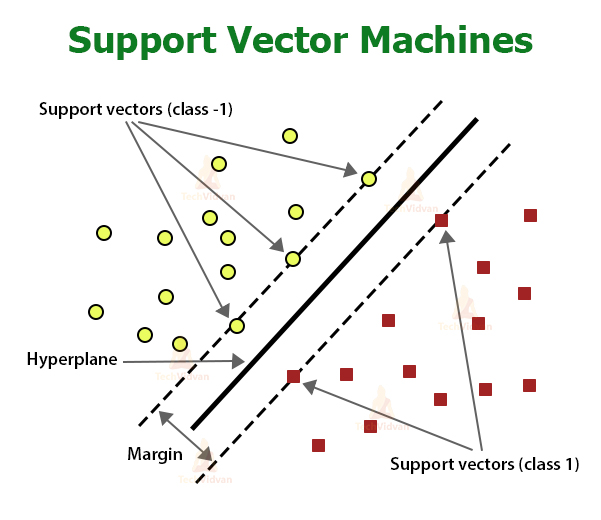

Let's take the simple SVM as an example, the working flow of the SVM algorithm can be simply summarized in two steps:
* Find boudaries (or hyperplane) that correctly separate the classes for the trainig data
* Picks the one that has the maximum distance from the closest data points


### Pros:

* More accurate
* Can be used in limited dataset
* Can deal with both linear and non-linearable data
* Can deal with high dimensional spaces, espcially when the number of features is greater than the number of samples
* Memory efficient since it only uses a subset of training points (support vectors) to train

### Cons:

* NOT suitable for large datasets, since it would take longer time for computation
* Overfitting might happen

---

## Implement

In this notebook, I will use this algorithm to train a classifier to automatically annotate single-cell RNA-seq data. The training data is an expert-annotated dataset. 

### About the Dataset

The Processed 3k Peripheral Blood Mononuclear Cells (PBMCs) Dataset consists of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics. There are 2,700 single cells that were sequenced on the Illumina NextSeq 500. 

### Tools

In order to do this, I need the following libraries:

* [matplotlib](http://metplotlib.org)
* [pandas](http://pandas.pydata.org)
* [numpy](https://numpy.org/doc/stable/index.html)
* [seaborn](https://seaborn.pydata.org/)
* [scanpy](https://scanpy.readthedocs.io/en/stable/)
* [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train_test_split#sklearn.model_selection.train_test_split) in [sklearn.model_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
* [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) and [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC) in [sklearn.svm](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
* [CalibratedClassifierCV](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html?highlight=calibratedclassifiercv#sklearn.calibration.CalibratedClassifierCV) in [sklearn.calibration](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.calibration)
* [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion_matrix#sklearn.metrics.confusion_matrix) in [sklearn.metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
* [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler) in [sklearn.preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)
* [scipy.sparse.linalg](https://docs.scipy.org/doc/scipy/reference/sparse.linalg.html)

The [Processed 3k PBMCs](https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.pbmc3k_processed.html) Dataset is loaded from [scanpy.datasets](https://scanpy.readthedocs.io/en/stable/api.html#module-scanpy.datasets).

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import scipy.sparse.linalg

### Data Exploration

I use a public dataset implemented in the scanpy package (the most popular single-cell framework in python). This dataset contains over 2000 human peripheral blood mononuclear cells.

In [2]:
adata = sc.datasets.pbmc3k_processed().raw.to_adata()

In [3]:
# print to see the data structure
print(adata)

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'


Let's take a look at meta data for the observes (cells).
The louvain column is the cell annotation (expert annotated from louvain clustering results).

In [4]:
adata.obs

,n_genes,percent_mito,n_counts,louvain
index,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells
...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0,CD14+ Monocytes
TTTCTACTGAGGCA-1,1227,0.009294,3443.0,B cells
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells


We want to build an SVM classifier to automatically annotate cells. Single-cell data is sparse and has many features (usually 10-20k), so we need to do dimensional reductions first (PCA).
We also want to perform PCA with a relatively small set of genes, e.g. 2000.
Here, we use the built-in function of scanpy to compute top_n variable genes

In [5]:
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=2000)
# We then only focus on these 2000 features (genes)
adata = adata[:, adata.var.highly_variable]

In [6]:
# Get the predictors (genes here; we will then do PCA)
X = adata.X
# The targets
Y = adata.obs['louvain']
Y.to_numpy()
# Split the training and testing set
X_train,X_val,y_train,y_val = train_test_split(X,Y,test_size=0.3, stratify=Y)

### Algorithm Implementation

In [7]:
# define a pca function
# pca for sparse matrix; modified from https://gist.github.com/julienr/8096321
def pca_sparse(X, npc):
    n_samples, n_features = X.shape
    Xmean = np.mean(X, axis=0)
    U, s, Vt = scipy.sparse.linalg.svds(X - Xmean, k=npc)
    order = np.argsort(-s) # sort s in descending order

    # svds returns U, s, Vt sorder in ascending order. We want descending
    s = s[order]
    W = Vt[order,:]
    U = U[:, order]

    explained_variance = (s**2) / float(n_samples)
    exp_var_ratio = explained_variance / explained_variance.sum()

    return U, s, W, exp_var_ratio

In [8]:
# do PCA with 50 dims
p = pca_sparse(X=X_train, npc=50)
# 
V = p[2].T
Us = np.matmul(p[0], np.diag(p[1]))
exp_var_thresh = 0.01
Us_sig = Us[:, p[3] > exp_var_thresh]

In [9]:
# check dimensions of Us_sig and V matrices; here we see top 8 dimensions can explain over 99% of variance
print(Us_sig.shape)
print(V.shape)

(1846, 8)
(2000, 50)


In [10]:
# project X_val to the same space
# get projection matrix
V_sig = V[:, p[3] > exp_var_thresh]
# center X_val
X_val_mean = np.mean(X_val, axis=0)
X_val_c = X_val - X_val_mean
# projection
X_val_p = np.matmul(X_val_c, V_sig)

In [11]:
# train
Classifier = SVC(kernel='rbf',gamma='scale',decision_function_shape='ovr')
clf = CalibratedClassifierCV(Classifier)
clf.fit(Us_sig, y_train)

CalibratedClassifierCV(base_estimator=SVC())

In [12]:
# predict
predicted = clf.predict(X_val_p)
# compute probability
prob = np.max(clf.predict_proba(X_val_p), axis = 1)
# label the cells with ambiguous prediction as 'Unknown'
# ambiguous means its max prediction probability is less than a threshold; used 0.5 here
unlabeled = np.where(prob < 0.5)
predicted[unlabeled] = 'Unknown'

### Build the confusion matrix

In [13]:
x_actu = pd.Series(y_val.to_numpy(), name='Actual')
x_pred = pd.Series(predicted, name='Predicted')
df_confusion = pd.crosstab(x_actu, x_pred)

### Visualization

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

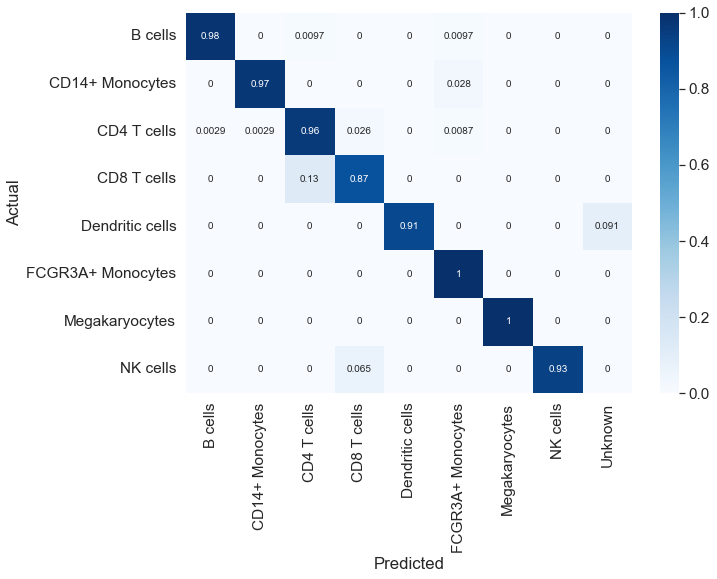

In [14]:
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_confusion.div(df_confusion.sum(axis=1), axis=0), cmap="Blues", annot=True,annot_kws={"size": 10})